In [81]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tabulate as tb
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("./../data/GOOGL.csv", parse_dates=['Date'], index_col='Date')
df = df[(df.index >= '2004-08-19') & (df.index <= '2019-12-19')]

#features = [
#    'Open', 'High', 'Low', 'Close', 'Volume',
#    'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
#    'BBL_20_2.0_2.0','BBM_20_2.0_2.0','BBU_20_2.0_2.0','BBB_20_2.0_2.0','BBP_20_2.0_2.0',
#    'ema_10','ema_20','ema_50','atr','stoch_k','stoch_d'
#]

features = [
    'Open'
]

target = 'Open'


sequence_length = 60
epochs = 1
batch_size=32

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, features.index(target)])  # next day's close

X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_test=df.index[sequence_length+split:] + pd.Timedelta(days=1)

print(tb.tabulate({
    'X_train shape': X_train.shape,
    'y_train shape': y_train.shape,
    'X_test shape': X_test.shape,
    'y_test shape': y_test.shape
}, headers='keys', tablefmt='psql'))

+-----------------+-----------------+----------------+----------------+
|   X_train shape |   y_train shape |   X_test shape |   y_test shape |
|-----------------+-----------------+----------------+----------------|
|            3002 |            3002 |            751 |            751 |
|              60 |                 |             60 |                |
|               1 |                 |              1 |                |
+-----------------+-----------------+----------------+----------------+


In [84]:
def create_lstm_model(sequence_length, features):
    """
    Create LSTM model similar to the paper's architecture
    """
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(96, return_sequences=True, input_shape=(sequence_length, features)))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(96, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Third LSTM layer
    model.add(LSTM(96, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Fourth LSTM layer
    model.add(LSTM(96))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model
model = create_lstm_model(sequence_length, len(features))

/home/michal/HDD/Univerity/WhiteRock/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1
)

94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - loss: 0.0033 - mae: 0.0338 - val_loss: 0.0047 - val_mae: 0.0609
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - loss: 0.0033 - mae: 0.0338 - val_loss: 0.0047 - val_mae: 0.0609


In [ ]:
predicted = model.predict(X_test)

close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[features.index(target)], scaler.scale_[features.index(target)]
predicted_prices = close_scaler.inverse_transform(predicted.reshape(-1,1))
predictions = pd.DataFrame({
    'Date': dates_test,
    'Predicted': predicted_prices.flatten()
})

actual_prices = df[target].values[sequence_length+split:]

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step


+-----+---------------------+-------------+---------------------+----------+
|     | DatesPredicted      |   Predicted | DatesActual         |   Actual |
|-----+---------------------+-------------+---------------------+----------|
| 746 | 2019-12-14 00:00:00 |     59.3473 | 2019-12-13 00:00:00 |  66.9333 |
| 747 | 2019-12-17 00:00:00 |     59.4128 | 2019-12-16 00:00:00 |  67.2859 |
| 748 | 2019-12-18 00:00:00 |     59.4862 | 2019-12-17 00:00:00 |  67.6539 |
| 749 | 2019-12-19 00:00:00 |     59.568  | 2019-12-18 00:00:00 |  67.3852 |
| 750 | 2019-12-20 00:00:00 |     59.6579 | 2019-12-19 00:00:00 |  67.1325 |
+-----+---------------------+-------------+---------------------+----------+


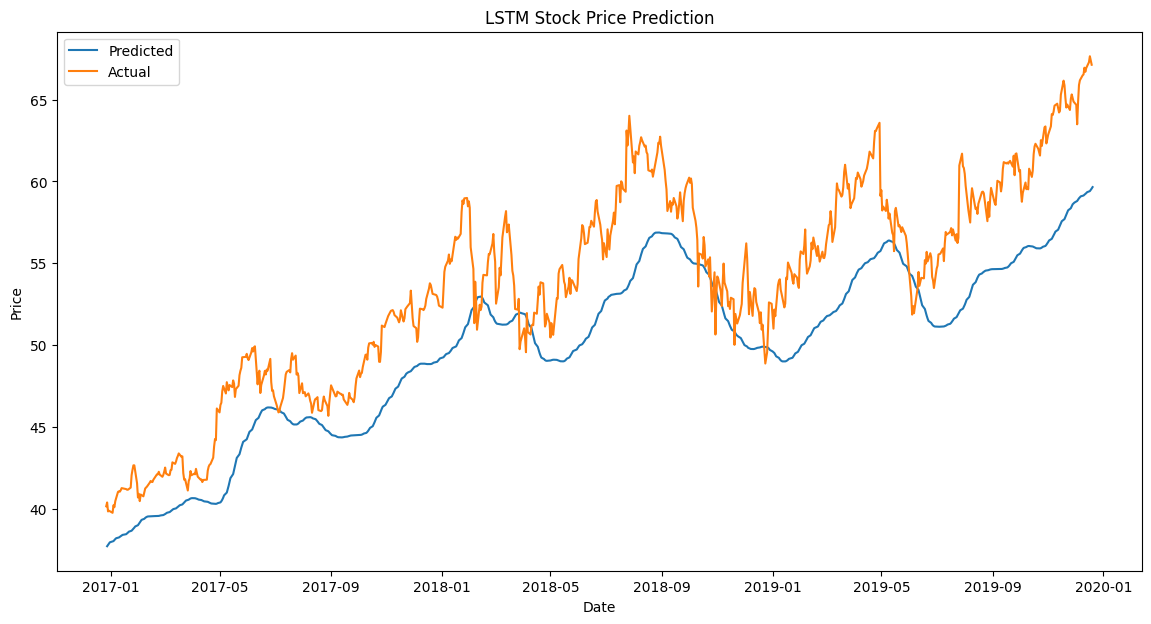

In [ ]:
plt_df = pd.DataFrame({
    'DatesPredicted': predictions['Date'],
    'Predicted': predictions['Predicted'],
    'DatesActual': predictions['Date'] - pd.Timedelta(days=1),
    'Actual': actual_prices
})
print(tb.tabulate(plt_df.tail(), headers='keys', tablefmt='psql'))

plt.figure(figsize=(14,7))
sns.lineplot(data=plt_df, x='DatesPredicted', y='Predicted', label='Predicted')
sns.lineplot(data=plt_df, x='DatesActual', y='Actual', label='Actual')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
movement_actual = np.sign(np.diff(actual_prices))
movement_predicted = np.sign(np.diff(predictions['Predicted']))
accuracy = np.mean(movement_actual == movement_predicted)
print(f"Movement Prediction Accuracy: {accuracy * 100:.2f}%")